In [1]:
%load_ext lab_black

In [2]:
# one hot encode runway
# ordinal encode airline
# TODO: Try with avg pb time, ratioH/M, ratio nominal
from traffic.core import Traffic

import pandas as pd
import numpy as np
import pickle

import os.path

from ipyleaflet import Polygon
from ipywidgets import Layout
from ipyleaflet import Map, Marker

import altair as alt

from cartes.osm import Overpass

from sklearn import svm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

from numpy import mean
from numpy import std
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
from ground_analysis.build_features import gather_data

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [5]:
from ground_analysis.utils import within_Xmin
from ground_analysis.extract_flight_info import onehot_runways

In [6]:
dep_arr_df = pd.read_pickle("../data/processed/dep_arr_df2.pkl")

In [7]:
dep_arr_df["mvt_type"].value_counts()

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ARR    19078
DEP    16464
Name: mvt_type, dtype: int64

In [8]:
from ground_analysis.extract_flight_info import assign_twy_occ

In [9]:
from pickle import load

with open("../data/intermediate/twy_occ_dictionnary.pkl", "rb") as f:
    d_twy = load(f)

In [10]:
dep_arr_df_twy = assign_twy_occ(dep_arr_df, d_twy)

# Rolling count of aircrafts

In [11]:
twy_cols = [
    "H_occ",
    "K_occ",
    "B_occ",
    "F_occ",
    "L_occ",
    "J_occ",
    "E_occ",
    "D_occ",
    "C_occ",
    "N_occ",
    "A_occ",
    "M_occ",
    "Y_occ",
    "R_occ",
    "G_occ",
    "Z_occ",
    "P_occ",
]

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
def twy_times2occ(df_times):
    """Given a dataframe with entry and exit times, convert it to get the occupancy over time"""
    new_df = df_times.melt(var_name="status", value_name="time").sort_values("time")
    new_df["counter"] = new_df["status"].map({"start": 1, "stop": -1}).cumsum()
    new_df.loc[new_df.counter < 0, "counter"] = 0
    return new_df


def rolling_max(df, dt_str="10T", time_col_name="time"):
    """Convert a occupancy dataframe (with counts, not entry and exit times) to a 'max occupancy'
    dataframe where"""
    return (
        df.sort_values(time_col_name)
        .set_index(time_col_name)
        .rolling(dt_str)
        .max()
        .reset_index()
    )

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
Eocc = twy_times2occ(d_twy["E"])
Eoccmax = rolling_max(Eocc, "10T")
Eoccmax

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time  counter
0     2019-10-01 03:59:08+00:00      1.0
1     2019-10-01 03:59:38+00:00      1.0
2     2019-10-01 04:16:49+00:00      1.0
3     2019-10-01 04:16:54+00:00      1.0
4     2019-10-01 04:22:52+00:00      1.0
...                         ...      ...
13467 2019-11-30 21:19:34+00:00      1.0
13468 2019-11-30 21:37:13+00:00      1.0
13469 2019-11-30 21:41:26+00:00      1.0
13470 2019-11-30 21:46:53+00:00      1.0
13471 2019-11-30 21:49:43+00:00      1.0

[13472 rows x 2 columns]

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

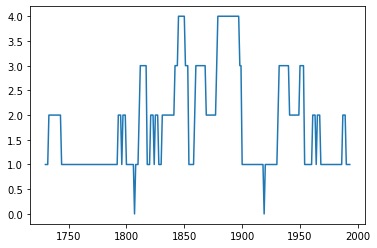

In [92]:
Eoccmax.sort_values("time").query(
    "time.dt.day == 7 & time.dt.month == 10"
).counter.plot()

In [99]:
twy_max_occ = rolling_max(
    dep_arr_df_twy[["first_movement_start"] + twy_cols],
    time_col_name="first_movement_start",
)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
datachart = twy_max_occ.query(
    "'2019-10-05 00:00:00+00:00'<first_movement_start<'2019-10-06 00:00:00+00:00'"
)

selection = alt.selection_multi(fields=["key"], bind="legend")
alt.Chart(datachart).transform_fold(twy_cols).mark_line().encode(
    alt.X("first_movement_start:T"),
    alt.Y("value:Q"),
    color=alt.condition(selection, "key:N", alt.value("lightgray")),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
).add_selection(selection).properties(width=900)

alt.Chart(...)

In [106]:
twy_max_occ.add_suffix("_max")

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


first_movement_start_max  H_occ_max  K_occ_max  B_occ_max  F_occ_max  \
0     2019-10-01 03:59:06+00:00        0.0        0.0        0.0        0.0   
1     2019-10-01 04:03:36+00:00        0.0        0.0        0.0        0.0   
2     2019-10-01 04:05:48+00:00        0.0        0.0        0.0        0.0   
3     2019-10-01 04:07:33+00:00        0.0        0.0        0.0        0.0   
4     2019-10-01 04:10:25+00:00        1.0        0.0        0.0        0.0   
...                         ...        ...        ...        ...        ...   
35537 2019-11-30 21:44:51+00:00        1.0        0.0        0.0        0.0   
35538 2019-11-30 21:46:26+00:00        1.0        0.0        0.0        0.0   
35539 2019-11-30 21:49:52+00:00        1.0        0.0        0.0        0.0   
35540 2019-11-30 21:53:56+00:00        1.0        0.0        0.0        0.0   
35541 2019-11-30 22:11:16+00:00        0.0        0.0        0.0        0.0   

       L_occ_max  J_occ_max  E_occ_max  D_occ_max  C_occ_max  N_occ_max  \
0            0.0        0.0        0.0        0.0        0.0        0.0   
1            0.0        0.0        0.0        0.0        0.0        0.0   
2            0.0        0.0        0.0        0.0        0.0        0.0   
3            0.0        0.0        0.0        0.0        0.0        0.0   
4            0.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
35537        0.0        0.0        1.0        0.0        0.0        0.0   
35538        0.0        0.0        1.0        0.0        0.0        0.0   
35539        0.0        0.0        1.0        0.0        0.0        0.0   
35540        0.0        0.0        0.0        0.0        0.0        0.0   
35541        0.0        0.0        0.0        0.0        0.0        0.0   

       A_occ_max  M_occ_max  Y_occ_max  R_occ_max  G_occ_max  Z_occ_max  \
0            0.0        0.0        0.0        0.0        0.0        0.0   
1            0.0        0.0        0.0        0.0        0.0        0.0   
2            1.0        0.0        0.0        0.0        0.0        0.0   
3            1.0        0.0        0.0        0.0        0.0        0.0   
4            1.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
35537        0.0        0.0        0.0        0.0        0.0        0.0   
35538        0.0        0.0        0.0        0.0        0.0        0.0   
35539        0.0        0.0        0.0        0.0        0.0        0.0   
35540        0.0        0.0        0.0        0.0        0.0        0.0   
35541        0.0        0.0        0.0        0.0        0.0        0.0   

       P_occ_max  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
...          ...  
35537        0.0  
35538        0.0  
35539        0.0  
35540        0.0  
35541        0.0  

[35542 rows x 18 columns]

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

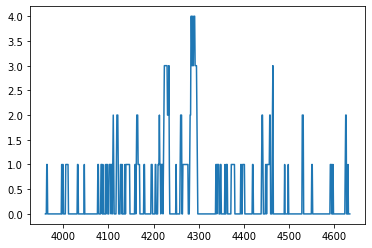

In [17]:
dep_arr_df_twy.query(
    "first_movement_start.dt.day == 7 & first_movement_start.dt.month== 10"
).E_occ.plot()

In [18]:
dep_arr_df_twy_E_occ_2 = pd.merge_asof(
    dep_arr_df_twy.sort_values("first_movement_start"),
    E_occ_2,
    left_on="first_movement_start",
    right_on="time",
)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
datachart = dep_arr_df_twy_E_occ_2[
    [
        "total_holding_time_minutes",
        "avg_outbound_delay_lastXmin",
        "F_occ",
        "K_occ",
        "counter",
    ]
]
alt.Chart(datachart).mark_boxplot().encode(
    x="counter", y="avg_outbound_delay_lastXmin", color="count()"
)

alt.Chart(...)

In [21]:
datachart = dep_arr_df_twy[
    ["total_holding_time_minutes", "avg_outbound_delay_lastXmin", "E_occ", "K_occ"]
]
alt.Chart(datachart).mark_boxplot().encode(x="E_occ", y="avg_outbound_delay_lastXmin")

alt.Chart(...)

In [121]:
def assign_twy_rolling_max(dep_arr_df_twy, twy_cols):
    # dep_arr_df_twy = assign_twy_occ(dep_arr_df, d_twy)
    twy_max_occ = rolling_max(
        dep_arr_df_twy[["first_movement_start"] + twy_cols],
        time_col_name="first_movement_start",
    )
    dep_arr_df_twy = dep_arr_df_twy.drop(twy_cols, axis=1)
    return pd.merge_asof(
        dep_arr_df_twy.sort_values("first_movement_start"),
        twy_max_occ,
        on="first_movement_start",
    )



/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


flight_id            on_runway_time taxi_holding_time  \
0      GSW4942_15738 2019-10-01 04:00:28+00:00   0 days 00:01:23   
1        EDW200_5718 2019-10-01 04:10:37+00:00   0 days 00:01:18   
2       SWR177_15809 2019-10-01 04:05:11+00:00   0 days 00:00:00   
3       SWR139_15706 2019-10-01 04:07:25+00:00   0 days 00:00:00   
4       SWR296_13638 2019-10-01 04:09:53+00:00   0 days 00:00:00   
...              ...                       ...               ...   
35537   SWR176_15653 2019-11-30 22:02:47+00:00   0 days 00:02:16   
35538   SWR288_13280 2019-11-30 21:49:46+00:00   0 days 00:02:03   
35539   THY8HD_18663 2019-11-30 21:49:30+00:00   0 days 00:00:00   
35540    SWR92_15689 2019-11-30 22:04:18+00:00   0 days 00:03:29   
35541   SWR138_15564 2019-11-30 22:12:48+00:00   0 days 00:00:00   

      rwy_holding_time total_holding_time  taxi_holding_time_minutes  \
0                 None    0 days 00:01:23                   1.383333   
1                 None    0 days 00:04:56                   1.300000   
2                 None    0 days 00:00:00                   0.000000   
3                 None    0 days 00:00:00                   0.000000   
4                 None    0 days 00:00:00                   0.000000   
...                ...                ...                        ...   
35537             None    0 days 00:15:41                   2.266667   
35538             None    0 days 00:02:03                   2.050000   
35539             None    0 days 00:00:00                   0.000000   
35540             None    0 days 00:09:35                   3.483333   
35541             None    0 days 00:00:00                   0.000000   

                 first_movement callsign registration typecode  ... D_occ  \
0     2019-10-01 03:59:06+00:00  GSW4942       HB-JOG     A319  ...   0.0   
1     2019-10-01 04:03:36+00:00   EDW200       HB-IHZ     A320  ...   0.0   
2     2019-10-01 04:05:48+00:00   SWR177       HB-JNI     B77W  ...   0.0   
3     2019-10-01 04:07:33+00:00   SWR139       HB-JNG     B77W  ...   0.0   
4     2019-10-01 04:10:25+00:00   SWR296       HB-JHM     A333  ...   0.0   
...                         ...      ...          ...      ...  ...   ...   
35537 2019-11-30 21:44:51+00:00   SWR176       HB-JNJ     B77W  ...   0.0   
35538 2019-11-30 21:46:26+00:00   SWR288       HB-JHI     A333  ...   0.0   
35539 2019-11-30 21:49:52+00:00   THY8HD       TC-JTN     A321  ...   0.0   
35540 2019-11-30 21:53:56+00:00    SWR92         None     None  ...   0.0   
35541 2019-11-30 22:11:16+00:00   SWR138       HB-JNH     B77W  ...   0.0   

      C_occ N_occ A_occ M_occ  Y_occ R_occ G_occ Z_occ P_occ  
0       0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  
1       0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  
2       0.0   0.0   1.0   0.0    0.0   0.0   0.0   0.0   0.0  
3       0.0   0.0   1.0   0.0    0.0   0.0   0.0   0.0   0.0  
4       0.0   0.0   1.0   0.0    0.0   0.0   0.0   0.0   0.0  
...     ...   ...   ...   ...    ...   ...   ...   ...   ...  
35537   0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  
35538   0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  
35539   0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  
35540   0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  
35541   0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  

[35542 rows x 78 columns]

# Predict delays thanks to sequences 

In [356]:
from sklearn.preprocessing import StandardScaler

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [357]:
twy_cols = [
    "H_occ",
    "K_occ",
    "B_occ",
    "F_occ",
    "L_occ",
    "J_occ",
    "E_occ",
    "D_occ",
    "C_occ",
    "N_occ",
    "A_occ",
    "M_occ",
    "Y_occ",
    "R_occ",
    "G_occ",
    "Z_occ",
    "P_occ",
]

dep_arr_df_twy_max = assign_twy_rolling_max(dep_arr_df_twy, twy_cols)
flight_df = dep_arr_df_twy_max.query(
    "avg_outbound_delay_lastXmin==avg_outbound_delay_lastXmin"
)

In [358]:
def assign_next_avg_delay(flight_df, dt="30T", name="nextAvgDelay"):
    dt_pred = pd.Timedelta(dt)
    target_df = (
        flight_df.sort_values("first_movement_start")[
            ["first_movement_start", "avg_outbound_delay_lastXmin"]
        ]
        .assign(first_movement_start=lambda x: x.first_movement_start - dt_pred)
        .rename(columns={"avg_outbound_delay_lastXmin": name})
    )
    return pd.merge_asof(
        flight_df.sort_values("first_movement_start"),
        target_df,
        on="first_movement_start",
    )

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [359]:
flight_df = assign_next_avg_delay(flight_df)

In [360]:
rwy_cols = ["rwy__10", "rwy__14", "rwy__16", "rwy__28", "rwy__32", "rwy__34"]

feature_columns = [
    "hh_num",
    #  "avg_outbound_delay_lastXmin",
    "nominal",
    "busy",
    "disrupted",
    "not_nom_arrival_ratio",
    "press",
    "temp",
    "atmap_visibility",
    "atmap_wind",
    "atmap_precipitation",
    "atmap_freezing",
    "atmap_danger",
    "nb_arr",
    "nb_dep",
    "nb",
    # "H",
    #  "L",
    # "L/M",
    # "M",
    "H_count",
    "L_count",
    "L/M_count",
    "M_count",
] + twy_cols
target_column = "nextAvgDelay"


flight_df = onehot_runways(flight_df)

data_df = (
    flight_df.sort_values("first_movement_start")
    .query("config=='NORTH0' ")[  # & mvt_type=='DEP' & end_pb==end_pb
        feature_columns + [target_column]
    ]
    .dropna()
)


input_df = data_df[feature_columns]
target_df = data_df[[target_column]]

sc = StandardScaler()
input_df = sc.fit_transform(input_df)
input_df = pd.DataFrame(input_df)

w_size = 15

input_data = np.array(
    [
        win.values.tolist()
        for win in input_df.rolling(w_size, axis=1)
        if win.shape[0] == w_size
    ][:-1]
)

target_data = data_df[[target_column]].iloc[w_size:].values

input_data.shape, target_data.shape

((11760, 15, 36), (11760, 1))

In [361]:
data_train, data_test, labels_train, labels_test = train_test_split(
    input_data, target_data, test_size=0.20, random_state=42
)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [362]:
from keras.layers.experimental import preprocessing
from keras import Sequential

In [363]:
from keras.layers import LSTM, GRU, Dense
from keras.optimizers import Adam

"""
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(data_train))
print(normalizer.mean.numpy())
"""
# optimizer
opt = Adam(learning_rate=0.01)
# design network
model = Sequential()
# model.add(normalizer)
model.add(
    GRU(
        64,
        input_shape=(data_train.shape[1], data_train.shape[2]),
        return_sequences=True
        # ropout=0.2,
    )
)
model.add(GRU(64))
model.add(Dense(1))
model.compile(loss="mae", optimizer=opt, metrics=["mse", "mae", "mape"])
# fit network

In [364]:
history = model.fit(
    data_train,
    labels_train,
    epochs=20,
    batch_size=32,
    validation_data=(data_test, labels_test),
    verbose=2,
    shuffle=False,
)

Epoch 1/20
294/294 - 55s - loss: 1.4217 - mse: 4.0354 - mae: 1.4217 - mape: 19207244.0000 - val_loss: 1.2160 - val_mse: 3.1032 - val_mae: 1.2160 - val_mape: 12863216.0000
Epoch 2/20
294/294 - 70s - loss: 1.1467 - mse: 2.7546 - mae: 1.1467 - mape: 16817572.0000 - val_loss: 1.1493 - val_mse: 2.7736 - val_mae: 1.1493 - val_mape: 13287098.0000
Epoch 3/20
294/294 - 80s - loss: 1.0425 - mse: 2.3663 - mae: 1.0425 - mape: 16793108.0000 - val_loss: 1.0602 - val_mse: 2.5270 - val_mae: 1.0602 - val_mape: 12619015.0000
Epoch 4/20
294/294 - 36s - loss: 0.9883 - mse: 2.2179 - mae: 0.9883 - mape: 16259359.0000 - val_loss: 1.0409 - val_mse: 2.5170 - val_mae: 1.0409 - val_mape: 11819134.0000
Epoch 5/20
294/294 - 20s - loss: 0.9453 - mse: 2.0311 - mae: 0.9453 - mape: 15187106.0000 - val_loss: 1.0425 - val_mse: 2.4190 - val_mae: 1.0425 - val_mape: 13308611.0000
Epoch 6/20
294/294 - 20s - loss: 0.9180 - mse: 1.9525 - mae: 0.9180 - mape: 15455565.0000 - val_loss: 0.9868 - val_mse: 2.3412 - val_mae: 0.9868 

In [365]:
import matplotlib.pyplot as plt

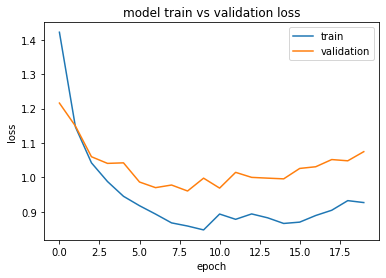

In [366]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

In [367]:
result_training = model.evaluate(data_test, labels_test)

74/74 [==============================] - 1s 16ms/step - loss: 1.0750 - mse: 2.6101 - mae: 1.0750 - mape: 12385360.0000


In [368]:
predicted = model.predict(data_test)


data_chart = pd.DataFrame(
    {"true": labels_test.reshape((1, -1))[0], "pred": predicted.reshape((1, -1))[0]}
)


predVStrue_chart = alt.Chart(data_chart).mark_circle(opacity=0.5).encode(
    x="true", y="pred"
) + alt.Chart(
    pd.DataFrame({"x": np.linspace(0, 15, 10), "y": np.linspace(0, 15, 10)})
).mark_line(
    color="black"
).encode(
    x="x", y="y"
)
display(predVStrue_chart)

alt.LayerChart(...)

In [369]:
" ".join(feature_columns)

'hh_num nominal busy disrupted not_nom_arrival_ratio press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger nb_arr nb_dep nb H_count L_count L/M_count M_count H_occ K_occ B_occ F_occ L_occ J_occ E_occ D_occ C_occ N_occ A_occ M_occ Y_occ R_occ G_occ Z_occ P_occ'

# Trying with LR Finder

In [64]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt


class LRFinder(Callback):
    def __init__(
        self,
        min_lr,
        max_lr,
        mom=0.9,
        stop_multiplier=None,
        reload_weights=True,
        batches_lr_update=5,
    ):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20 * self.mom / 3 + 10  # 4 if mom=0.9
            # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier

    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p["epochs"] * p["samples"] // p["batch_size"]
        except:
            n_iterations = p["steps"] * p["epochs"]

        self.learning_rates = np.geomspace(
            self.min_lr, self.max_lr, num=n_iterations // self.batches_lr_update + 1
        )
        self.losses = []
        self.iteration = 0
        self.best_loss = 0
        if self.reload_weights:
            self.model.save_weights("tmp.hdf5")

    def on_batch_end(self, batch, logs={}):
        loss = logs.get("loss")

        if self.iteration != 0:  # Make loss smoother using momentum
            loss = self.losses[-1] * self.mom + loss * (1 - self.mom)

        if self.iteration == 0 or loss < self.best_loss:
            self.best_loss = loss

        if (
            self.iteration % self.batches_lr_update == 0
        ):  # Evaluate each lr over 5 epochs

            if self.reload_weights:
                self.model.load_weights("tmp.hdf5")

            lr = self.learning_rates[self.iteration // self.batches_lr_update]
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)

        if loss > self.best_loss * self.stop_multiplier:  # Stop criteria
            self.model.stop_training = True

        self.iteration += 1

    def on_train_end(self, logs=None):
        if self.reload_weights:
            self.model.load_weights("tmp.hdf5")

        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[: len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale("log")
        plt.show()

Epoch 1/2
147/147 [==============================] - 14s 67ms/step - loss: 4.3209 - mse: 23.7701 - mae: 4.3209 - mape: 1252958.0135
Epoch 2/2
147/147 [==============================] - 9s 59ms/step - loss: 3.3319 - mse: 16.7566 - mae: 3.3319 - mape: 11565826.8049


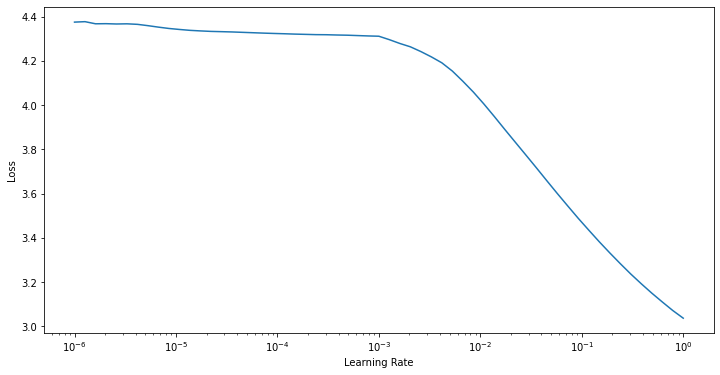

In [65]:
lr_finder = LRFinder(min_lr=1e-6, max_lr=1)

model.fit(data_train, labels_train, batch_size=64, callbacks=[lr_finder], epochs=2)

# Classifier

In [299]:
twy_cols = [
    "H_occ",
    "K_occ",
    "B_occ",
    "F_occ",
    "L_occ",
    "J_occ",
    "E_occ",
    "D_occ",
    "C_occ",
    "N_occ",
    "A_occ",
    "M_occ",
    "Y_occ",
    "R_occ",
    "G_occ",
    "Z_occ",
    "P_occ",
]

dep_arr_df_twy_max = assign_twy_rolling_max(dep_arr_df_twy, twy_cols)
flight_df = dep_arr_df_twy_max.query(
    "avg_outbound_delay_lastXmin==avg_outbound_delay_lastXmin"
)

In [300]:
flight_df = assign_next_avg_delay(flight_df)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [301]:
flight_df["nextAvgDelay_cat"] = np.where(flight_df["nextAvgDelay"] >= 8, 1, 0)

In [302]:
rwy_cols = ["rwy__10", "rwy__14", "rwy__16", "rwy__28", "rwy__32", "rwy__34"]

feature_columns = [
    "hh_num",
    #  "avg_outbound_delay_lastXmin",
    "nominal",
    "busy",
    "disrupted",
    "not_nom_arrival_ratio",
    "press",
    "temp",
    "atmap_visibility",
    "atmap_wind",
    "atmap_precipitation",
    "atmap_freezing",
    "atmap_danger",
    "nb_arr",
    "nb_dep",
    "nb",
    # "H",
    #  "L",
    # "L/M",
    # "M",
    "H_count",
    "L_count",
    "L/M_count",
    "M_count",
] + twy_cols
target_column = "nextAvgDelay_cat"


flight_df = onehot_runways(flight_df)

data_df = (
    flight_df.sort_values("first_movement_start")
    .query("config=='NORTH0' ")[  # & mvt_type=='DEP' & end_pb==end_pb
        feature_columns + [target_column]
    ]
    .dropna()
)


input_df = data_df[feature_columns]
target_df = data_df[[target_column]]

sc = StandardScaler()
input_df = sc.fit_transform(input_df)
input_df = pd.DataFrame(input_df)

w_size = 15

input_data = np.array(
    [
        win.values.tolist()
        for win in input_df.rolling(w_size, axis=1)
        if win.shape[0] == w_size
    ][:-1]
)

target_data = data_df[[target_column]].iloc[w_size:].values

input_data.shape, target_data.shape

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((11760, 15, 36), (11760, 1))

In [303]:
data_train, data_test, labels_train, labels_test = train_test_split(
    input_data, target_data, test_size=0.20, random_state=42
)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [304]:
from keras.layers.experimental import preprocessing
from keras import Sequential

In [305]:
from sklearn.utils import class_weight

labels_train_melted = labels_train.reshape((1, -1))[0]

class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(labels_train_melted), y=labels_train_melted
)
class_weights = {i: v for i, v in enumerate(class_weights)}
class_weights

{0: 0.5336963921034718, 1: 7.91919191919192}

In [306]:
from keras.layers import LSTM, GRU, Dense
from keras.optimizers import Adam

"""
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(data_train))
print(normalizer.mean.numpy())
"""
# optimizer
opt = Adam(learning_rate=0.01)
# design network
model = Sequential()
# model.add(normalizer)
model.add(
    LSTM(
        64,
        input_shape=(data_train.shape[1], data_train.shape[2]),
        return_sequences=True,
        dropout=0.3,
    )
)
model.add(LSTM(64))
model.add(Dense(1, activation="sigmoid"))  # sigmoid to have probability between 0 and 1
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# fit network

### LR FINDER

Epoch 1/2
294/294 [==============================] - 22s 61ms/step - loss: 0.6969 - accuracy: 0.4901
Epoch 2/2
294/294 [==============================] - 17s 57ms/step - loss: 0.5116 - accuracy: 0.7894


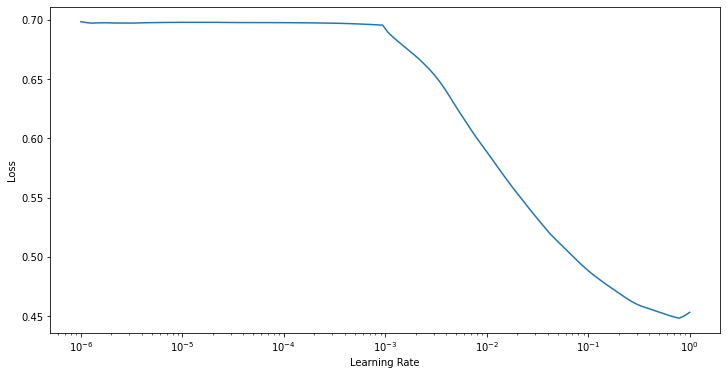

In [307]:
lr_finder = LRFinder(min_lr=1e-6, max_lr=1)

model.fit(data_train, labels_train, batch_size=32, callbacks=[lr_finder], epochs=2)

In [281]:
history = model.fit(
    data_train,
    labels_train,
    epochs=25,
    batch_size=32,
    validation_data=(data_test, labels_test),
    verbose=2,
    shuffle=False,
    class_weight=class_weights,
)

Epoch 1/25
294/294 - 54s - loss: 0.5196 - accuracy: 0.7982 - val_loss: 0.4288 - val_accuracy: 0.8648
Epoch 2/25
294/294 - 74s - loss: 0.3828 - accuracy: 0.8647 - val_loss: 0.3391 - val_accuracy: 0.8793
Epoch 3/25
294/294 - 67s - loss: 0.3324 - accuracy: 0.8895 - val_loss: 0.3053 - val_accuracy: 0.8873
Epoch 4/25
294/294 - 68s - loss: 0.2773 - accuracy: 0.8953 - val_loss: 0.2598 - val_accuracy: 0.8924
Epoch 5/25
294/294 - 88s - loss: 0.2504 - accuracy: 0.9109 - val_loss: 0.2640 - val_accuracy: 0.9039
Epoch 6/25
294/294 - 55s - loss: 0.2174 - accuracy: 0.9186 - val_loss: 0.2329 - val_accuracy: 0.9090
Epoch 7/25
294/294 - 21s - loss: 0.2086 - accuracy: 0.9233 - val_loss: 0.2588 - val_accuracy: 0.9026
Epoch 8/25
294/294 - 19s - loss: 0.2016 - accuracy: 0.9279 - val_loss: 0.2655 - val_accuracy: 0.9039
Epoch 9/25
294/294 - 20s - loss: 0.2010 - accuracy: 0.9242 - val_loss: 0.2335 - val_accuracy: 0.9209
Epoch 10/25
294/294 - 21s - loss: 0.1848 - accuracy: 0.9188 - val_loss: 0.1876 - val_accura

### Results

In [282]:
import matplotlib.pyplot as plt

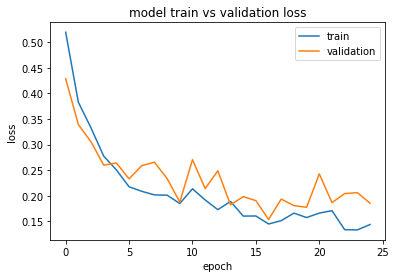

In [283]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

In [284]:
result_training = model.evaluate(data_test, labels_test)

74/74 [==============================] - 25s 291ms/step - loss: 0.1854 - accuracy: 0.9384


In [285]:
from sklearn.metrics import (
    plot_confusion_matrix,
    classification_report,
    confusion_matrix,
)

In [286]:
predicted = model.predict(data_test)

In [287]:
pred = predicted.round()

In [288]:
pred, truth = pred.reshape((1, -1))[0], labels_test.reshape((1, -1))[0]

In [289]:
confusion_matrix(truth, pred, normalize="true")

array([[0.94101509, 0.05898491],
       [0.0969697 , 0.9030303 ]])

In [293]:
confusion_matrix(truth, pred, normalize=None)

array([[2058,  129],
       [  16,  149]])

In [458]:
print(classification_report(truth, pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2187
           1       0.54      0.90      0.67       165

    accuracy                           0.94      2352
   macro avg       0.76      0.92      0.82      2352
weighted avg       0.96      0.94      0.95      2352



/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [294]:
from keras.models import load_model

In [296]:
filename = '01_LSTM_dropout_classifier_8min_avgdelay_balanced'
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("../model/"+filename)

In [297]:
# Let's check:
np.testing.assert_allclose(
    model.predict(data_test), reconstructed_model.predict(data_test)
)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Trying to apply it to 20/10 between 8am and 9am


In [414]:
target_column = "nextAvgDelay_cat"

In [439]:
df = flight_df.query(
    '"2019-10-21 00:00:00+00:00"<first_movement_start<"2019-10-30 00:00:00+00:00"'
)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [440]:
df["nextAvgDelay_cat"] = np.where(df["nextAvgDelay"] >= 8, 1, 0)

data_df = (
    df.sort_values("first_movement_start")
    .query("config=='NORTH0' ")  # & mvt_type=='DEP' & end_pb==end_pb
)

<ipython-input-440-ade895744a7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["nextAvgDelay_cat"] = np.where(df["nextAvgDelay"] >= 8, 1, 0)


In [441]:
input_df = data_df[feature_columns]
target_df = data_df[[target_column]]

input_df = sc.transform(input_df)
input_df = pd.DataFrame(input_df)

w_size = 15

input_data = np.array(
    [
        win.values.tolist()
        for win in input_df.rolling(w_size, axis=1)
        if win.shape[0] == w_size
    ][:-1]
)

target_data = data_df[[target_column]].iloc[w_size:].values

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [442]:
input_data.shape, target_data.shape

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((2001, 15, 36), (2001, 1))

In [443]:
sample_probs = model.predict(input_data)

In [454]:
data_df.iloc[w_size:].columns

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['hh_num', 'nominal', 'busy', 'disrupted', 'not_nom_arrival_ratio',
       'press', 'temp', 'atmap_visibility', 'atmap_wind',
       'atmap_precipitation', 'atmap_freezing', 'atmap_danger', 'nb_arr',
       'nb_dep', 'nb', 'H_count', 'L_count', 'L/M_count', 'M_count', 'H_occ',
       'K_occ', 'B_occ', 'F_occ', 'L_occ', 'J_occ', 'E_occ', 'D_occ', 'C_occ',
       'N_occ', 'A_occ', 'M_occ', 'Y_occ', 'R_occ', 'G_occ', 'Z_occ', 'P_occ',
       'nextAvgDelay_cat'],
      dtype='object')

In [444]:
sample_preds = sample_probs.round()
sample_preds.shape

(2001, 1)

In [445]:
target_data.shape

(2001, 1)

In [446]:
sample_pred_truth_df = pd.DataFrame(
    {
        "pred": pd.Series(sample_preds.reshape((1, -1))[0]),
        "truth": pd.Series(target_data.reshape((1, -1))[0]),
    }
)

In [ ]:
alt.Chart(sample_pred_truth_df.reset_index).mark_bar().encode(x=)

<AxesSubplot:>

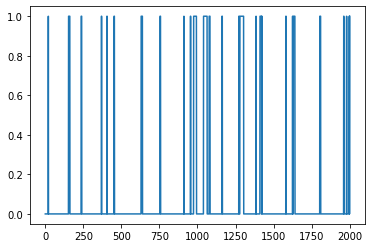

In [447]:
sample_pred_truth_df.pred.plot()

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

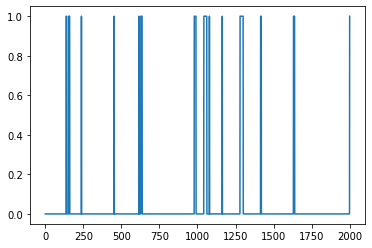

In [448]:
sample_pred_truth_df.truth.plot()

In [425]:
df = df.sort_values("first_movement_start")

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [426]:
df.shape

(309, 85)

In [428]:
datachart = df[["first_movement_start", "avg_outbound_delay_lastXmin", "nextAvgDelay"]]


curr_avg_chart = (
    alt.Chart(datachart)
    .mark_line()
    .encode(x="first_movement_start:T", y="avg_outbound_delay_lastXmin:Q")
)
next_avg_chart = (
    alt.Chart(datachart)
    .mark_line(color="red")
    .encode(x="first_movement_start:T", y="nextAvgDelay:Q")
)
next_avg_chart

alt.Chart(...)

# Regressor with twy and sifis

In [464]:
dep_arr_df = pd.read_pickle("../data/processed/dep_arr_df5_sifiAqliScfi.pkl")

In [465]:
dep_arr_df.columns

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['flight_id', 'on_runway_time', 'taxi_holding_time', 'rwy_holding_time',
       'total_holding_time', 'taxi_holding_time_minutes', 'first_movement',
       'callsign', 'registration', 'typecode', 'icao24', 'firstseen_min',
       'start', 'stop', 'duration', 'cumdist_max', 'parking_position',
       'parking_position_duration', 'runway', 'pb_duration', 'end_pb',
       'duration_minutes', 'parking_position_duration_minutes',
       'pb_duration_minutes', 'first_movement_start', 'taxi_dist',
       'total_holding_time_minutes', 'real_dur', 'real_dur_minutes', 'airline',
       'hh', 'hh_num', 'angle_sum', 'avg_speed', 'mvt_type', 'taxiing_stop',
       'avg_outbound_delay_lastXmin', 'turnaround', 'turnaround_minutes',
       'NDepDep', 'nominal', 'busy', 'disrupted', 'not_nom_arrival_ratio',
       'press', 'temp', 'atmap_visibility', 'atmap_wind',
       'atmap_precipitation', 'atmap_freezing', 'atmap_danger', 'atmap_score',
       'config', 'nb_arr', 'nb_dep', 'nb', 'icao_wtc', 

In [461]:
sifi_cols = ["aqli_DEP", "scfi_DEP", "aqli_ARR", "scfi_ARR"]

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [466]:
flight_df = dep_arr_df

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [467]:
twy_cols = [
    "H_occ",
    "K_occ",
    "B_occ",
    "F_occ",
    "L_occ",
    "J_occ",
    "E_occ",
    "D_occ",
    "C_occ",
    "N_occ",
    "A_occ",
    "M_occ",
    "Y_occ",
    "R_occ",
    "G_occ",
    "Z_occ",
    "P_occ",
]

In [468]:
rwy_cols = ["rwy__10", "rwy__14", "rwy__16", "rwy__28", "rwy__32", "rwy__34"]

feature_columns = (
    [
        "hh_num",
        #  "avg_outbound_delay_lastXmin",
        "nominal",
        "busy",
        "disrupted",
        "not_nom_arrival_ratio",
        "press",
        "temp",
        "atmap_visibility",
        "atmap_wind",
        "atmap_precipitation",
        "atmap_freezing",
        "atmap_danger",
        "nb_arr",
        "nb_dep",
        "nb",
        # "H",
        #  "L",
        # "L/M",
        # "M",
        "H_count",
        "L_count",
        "L/M_count",
        "M_count",
    ]
    + twy_cols
    + sifi_cols
)
target_column = "total_holding_time_minutes"  # "nextAvgDelay"


flight_df = onehot_runways(flight_df)

data_df = (
    flight_df.sort_values("first_movement_start")
    .query("config=='NORTH0' ")[  # & mvt_type=='DEP' & end_pb==end_pb
        feature_columns + [target_column]
    ]
    .dropna()
)


input_df = data_df[feature_columns]
target_df = data_df[[target_column]]

sc = StandardScaler()
input_df = sc.fit_transform(input_df)
input_df = pd.DataFrame(input_df)

w_size = 15

input_data = np.array(
    [
        win.values.tolist()
        for win in input_df.rolling(w_size, axis=1)
        if win.shape[0] == w_size
    ][:-1]
)

target_data = data_df[[target_column]].iloc[w_size:].values

input_data.shape, target_data.shape

((25045, 15, 40), (25045, 1))

In [469]:
data_train, data_test, labels_train, labels_test = train_test_split(
    input_data, target_data, test_size=0.20, random_state=42
)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [470]:
from keras.layers.experimental import preprocessing
from keras import Sequential

In [471]:
from keras.layers import LSTM, GRU, Dense
from keras.optimizers import Adam

"""
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(data_train))
print(normalizer.mean.numpy())
"""
# optimizer
opt = Adam(learning_rate=0.01)
# design network
model = Sequential()
# model.add(normalizer)
model.add(
    LSTM(
        64,
        input_shape=(data_train.shape[1], data_train.shape[2]),
        return_sequences=True
        # ropout=0.2,
    )
)
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss="mae", optimizer=opt, metrics=["mse", "mae", "mape"])
# fit network

In [472]:
history = model.fit(
    data_train,
    labels_train,
    epochs=20,
    batch_size=32,
    validation_data=(data_test, labels_test),
    verbose=2,
    shuffle=False,
)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

In [ ]:
result_training = model.evaluate(data_test, labels_test)

In [ ]:
predicted = model.predict(data_test)


data_chart = pd.DataFrame(
    {"true": labels_test.reshape((1, -1))[0], "pred": predicted.reshape((1, -1))[0]}
)


predVStrue_chart = alt.Chart(data_chart).mark_circle(opacity=0.5).encode(
    x="true", y="pred"
) + alt.Chart(
    pd.DataFrame({"x": np.linspace(0, 15, 10), "y": np.linspace(0, 15, 10)})
).mark_line(
    color="black"
).encode(
    x="x", y="y"
)
display(predVStrue_chart)

In [ ]:
" ".join(feature_columns)